# Symbolic PINNs

## Case studies 1 with initial condition follow: phase angle = -1rad, transient speed  = 7rad/s.

### Classical method

In [1]:
using OrdinaryDiffEq            # package use to create and solve ODEs.

# Define the ODEs system for SMIB.
function SMIB(du,u,p,t)
    du[1] = u[2]
    du[2] = 5- 10*sin(u[1])-1.7*u[2]
end;

In [2]:
u0 = [-1.0, 7.0]                    #Initial conditions.
h = 0.01                            #Time steps.
tspan = (0.0,10.0)                  #Observed interval.
prob = ODEProblem(SMIB,u0,tspan);   #Define the ODEs problem which solved by ODE solvers.
sol = solve(prob,Tsit5(),dt = h,adaptive = false);
sol = transpose(sol);               #Using transpose function to plot save to CSV file.

### PINNs method

In [3]:
using NeuralPDE              #Package to create a PINNs.
using Lux                    #Package to create a layer of PINNs.
using ModelingToolkit        #Package for high-performance symbolic-numeric computation (symbolic interface).
using Optimization           #Package to create a optimazation problems and optimize the loss function.
using OptimizationOptimJL    #Package to create a optimazation problems and optimize the loss function.
using LineSearches           #Package using the linear search method to improved the optimization process.

import ModelingToolkit: Interval, infimum, supremum

@parameters t                #Define the independent variable.
@variables u1(..), u2(..)    #Define the dependent variables.
D = Differential(t)          #Define the differential operater with respect to time.

#Define the equations of SMIB by PDE format.
eq = [D(u1(t)) ~ u2(t),
    D(u2(t)) ~ 5 - 10*sin(u1(t))-1.7*u2(t)];

In [ ]:
bcs = [u1(0) ~ -1.0, u2(0) ~ 7.0]       #Boundary conditions (for ODEs it is the initial conditions).
domains = [t ∈ Interval(0.0,10.0)]      #Observed interval.
dt = 0.01                               #Time steps.

input_ = length(domains)                #Number of dimensions
n = 10                                  #Number of neurons in each hidden layer.

#Create a network.
#Chain: Collects multiple layers / functions to be called in sequence on a given input.
#Dense: Create a traditional fully connected layer, whose forward pass is given by: y = activation.(weight * x .+ bias).
#Reader can visit "https://docs.juliahub.com/Lux/Jbrqh/0.4.24/autodocs/" for more information.
chain =[Lux.Chain(Dense(input_,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,1)) for _ in 1:2]

@named pde_system = PDESystem(eq,bcs,domains,[t],[u1(t),u2(t)])   #Define the PDE system.

#Define strategy to evaluate the PDE loss terms.
strategy = NeuralPDE.GridTraining(dt)
discretization = PhysicsInformedNN(chain, strategy)

#Taking apart the pieces the loss functions.
sym_prob = NeuralPDE.symbolic_discretize(pde_system, discretization)
pde_loss_functions = sym_prob.loss_functions.pde_loss_functions
bc_loss_functions = sym_prob.loss_functions.bc_loss_functions

iter = 0
maxiters = 50000
callback = function (p, l)
    global iter
    #Show the loss after 100 iterations.
    if iter % 100 == 0 || iter == maxiters
        println("loss: ", l,"\t\t","Iterations: $iter")
    end
    iter += 1
    return false
end

#Reassembling the loss functions.
loss_functions =  [pde_loss_functions;bc_loss_functions]


function loss_function(θ,p)
    sum(map(l->l(θ) ,loss_functions))
end

# Create and solve the optimization problem based on the loss function.
f_ = OptimizationFunction(loss_function, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f_, sym_prob.flat_init_params)
res = Optimization.solve(prob,OptimizationOptimJL.BFGS(linesearch=LineSearches.BackTracking()); callback = callback, maxiters = maxiters)

#Get the structure of network to predict the state after training.
phi = discretization.phi

In [5]:
chain   #Showing the information of network.

2-element Vector{Chain{NamedTuple{(:layer_1, :layer_2, :layer_3, :layer_4), Tuple{Dense{true, typeof(tanh_fast), typeof(glorot_uniform), typeof(zeros32)}, Dense{true, typeof(tanh_fast), typeof(glorot_uniform), typeof(zeros32)}, Dense{true, typeof(tanh_fast), typeof(glorot_uniform), typeof(zeros32)}, Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}, Nothing}}:
 Chain()             # 251 parameters
 Chain()             # 251 parameters

In [6]:
#Define a set of time and generate the predict.
ts = 0.0:0.01:10.0
minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:2]

#Predict the state.
u_predict  = [[phi[i]([t],minimizers_[i])[1] for t in ts] for i in 1:2];

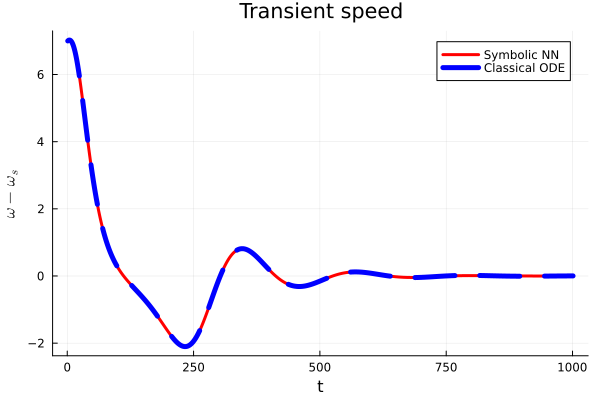

In [38]:
#Plotting the results.
using Plots
plot(u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,2],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Transient speed")
xlabel!("t")
ylabel!("\$ \\omega - \\omega_s \$")

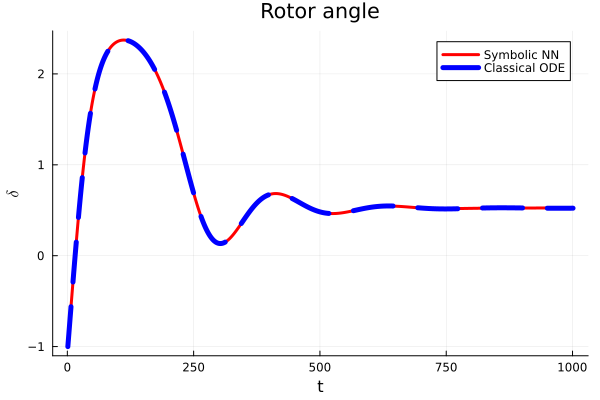

In [39]:
#Plotting the results.
using Plots
plot(u_predict[1,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Rotor angle")
xlabel!("t")
ylabel!("\$ \\delta \$")

### Saving results

In [ ]:
using DataFrames
using CSV
df = DataFrame(delta_NN = u_predict[1], omega_NN = u_predict[2], delta_ODE = sol[:,1], omega_ODE=sol[:,2]) #delta = -1, transient = 7
CSV.write("filename.csv", df; append = false)

### Saving and reload the pre-trained weight

In [ ]:
using JLD2
save("filename.jld2",Dict("SMIB" => res.u.depvar))

In [57]:
using JLD2
using DataFrames
using CSV
init_param = load("filename.jld2")

Dict{String, Any} with 1 entry:
  "SIMB" => (u1 = (layer_1 = (weight = [-0.534109; 0.194995; … ; -0.2476; -0.46…

## Case studies 2 with initial condition follow: phase angle = 1rad, transient speed  = -5rad/s.

#### PINNS

In [58]:
@parameters t
@variables u1(..), u2(..)
D = Differential(t)
eq = [D(u1(t)) ~ u2(t),
    D(u2(t)) ~ 5 - 10*sin(u1(t))-1.7*u2(t)];

In [ ]:
bcs = [u1(0) ~ 1.0, u2(0) ~ -5.0]
domains = [t ∈ Interval(0.0,10.0)]
dt = 0.01

input_ = length(domains) # number of dimensions
n = 10
chain =[Lux.Chain(Dense(input_,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,1)) for _ in 1:2]

@named pde_system = PDESystem(eq,bcs,domains,[t],[u1(t),u2(t)])

strategy = NeuralPDE.GridTraining(dt)
discretization = PhysicsInformedNN(chain, strategy, init_params = init_param["SMIB"])
sym_prob = NeuralPDE.symbolic_discretize(pde_system, discretization)

pde_loss_functions = sym_prob.loss_functions.pde_loss_functions
bc_loss_functions = sym_prob.loss_functions.bc_loss_functions

iter = 0
maxiters = 50000
callback = function (p, l)
    global iter
    #Show the loss after 100 iterations.
    if iter % 100 == 0 || iter == maxiters
        println("loss: ", l,"\t\t","Iterations: $iter")
    end
    iter += 1
    return false
end

loss_functions =  [pde_loss_functions;bc_loss_functions]

function loss_function(θ,p)
    sum(map(l->l(θ) ,loss_functions))
end

f_ = OptimizationFunction(loss_function, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f_, sym_prob.flat_init_params)
res = Optimization.solve(prob,OptimizationOptimJL.BFGS(linesearch=LineSearches.BackTracking()); callback = callback, maxiters = maxiters)

In [60]:
phi = discretization.phi
ts = 0.0:0.01:10.0
minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:2]
u_predict  = [[phi[i]([t],minimizers_[i])[1] for t in ts] for i in 1:2];

#### Classical

In [61]:
function SMIB(du,u,p,t)
    du[1] = u[2]
    du[2] = 5- 10*sin(u[1])-1.7*u[2]
end
u0 = [1.0, -5.0]
h = 0.01
tspan = (0.0,10.0)
prob = ODEProblem(SMIB,u0,tspan);
sol = solve(prob,Tsit5(),dt = h,adaptive = false); # this is regular ODE
sol = transpose(sol);

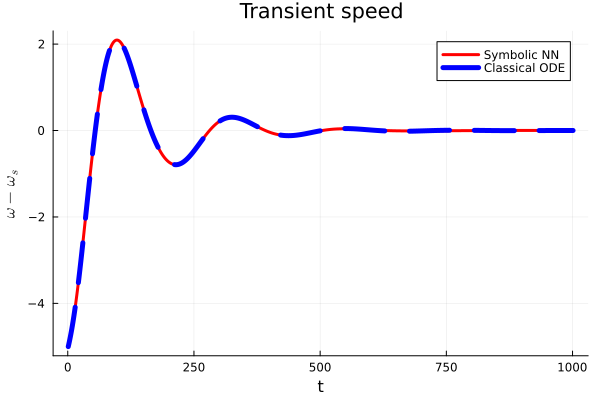

In [62]:
#Plotting the results.
using Plots
plot(u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,2],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Transient speed")
xlabel!("t")
ylabel!("\$ \\omega - \\omega_s \$")

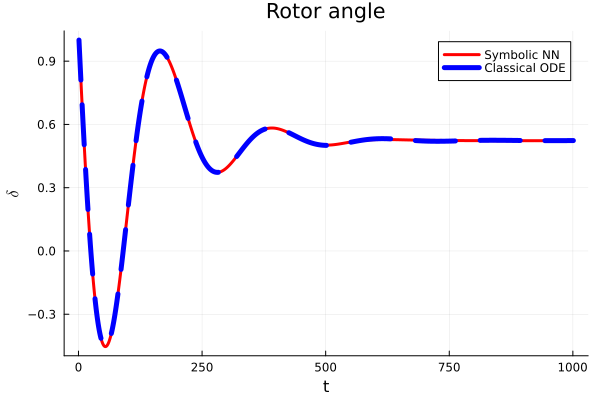

In [63]:
#Plotting the results.
using Plots
plot(u_predict[1,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Rotor angle")
xlabel!("t")
ylabel!("\$ \\delta \$")

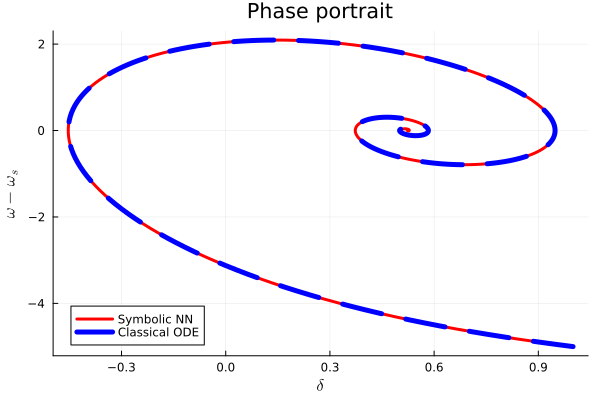

In [67]:
#Plotting the results.
using Plots
plot(u_predict[1,:], u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],sol[:,2], ls=:dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Phase portrait")
ylabel!("\$ \\omega - \\omega_s \$")
xlabel!("\$ \\delta \$")

In [ ]:
using DataFrames
using CSV
df = DataFrame(delta_NN = u_predict[1], omega_NN = u_predict[2], delta_ODE = sol[:,1], omega_ODE=sol[:,2])
CSV.write("filename.csv", df; append = false) 

### Case studies 3 with initial condition follow: phase angle = 0rad, transient speed  = 2rad/s.

#### PINNs

In [68]:
@parameters t
@variables u1(..), u2(..)
D = Differential(t)
eq = [D(u1(t)) ~ u2(t),
    D(u2(t)) ~ 5 - 10*sin(u1(t))-1.7*u2(t)];

In [ ]:
bcs = [u1(0) ~ 0.0, u2(0) ~ 2.0]
domains = [t ∈ Interval(0.0,10.0)]
dt = 0.01

input_ = length(domains) # number of dimensions
n = 10
chain =[Lux.Chain(Dense(input_,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,1)) for _ in 1:2]

@named pde_system = PDESystem(eq,bcs,domains,[t],[u1(t),u2(t)])

strategy = NeuralPDE.GridTraining(dt)

#The code using transfer model.
discretization = PhysicsInformedNN(chain, strategy, init_params = init_param["SMIB"])

#The code without using transfer model.
# discretization = PhysicsInformedNN(chain, strategy)

sym_prob = NeuralPDE.symbolic_discretize(pde_system, discretization)

pde_loss_functions = sym_prob.loss_functions.pde_loss_functions
bc_loss_functions = sym_prob.loss_functions.bc_loss_functions

iter = 0
maxiters = 50000
callback = function (p, l)
    global iter
    #Show the loss after 100 iterations.
    if iter % 100 == 0 || iter == maxiters
        println("loss: ", l,"\t\t","Iterations: $iter")
    end
    iter += 1
    return false
end

loss_functions =  [pde_loss_functions;bc_loss_functions]

function loss_function(θ,p)
    sum(map(l->l(θ) ,loss_functions))
end

f_ = OptimizationFunction(loss_function, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f_, sym_prob.flat_init_params)
res = Optimization.solve(prob,OptimizationOptimJL.BFGS(linesearch=LineSearches.BackTracking()); callback = callback, maxiters = maxiters)

In [ ]:
phi = discretization.phi
ts = 0.0:0.01:10.0
minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:2]
u_predict  = [[phi[i]([t],minimizers_[i])[1] for t in ts] for i in 1:2];

#### Clascical

In [72]:
function SMIB(du,u,p,t)
    du[1] = u[2]
    du[2] = 5- 10*sin(u[1])-1.7*u[2]
end
u0 = [0.0, 2.0]
h = 0.01
tspan = (0.0,10.0)
prob = ODEProblem(SMIB,u0,tspan);
sol = solve(prob,Tsit5(),dt = h,adaptive = false); # this is regular ODE
sol = transpose(sol);

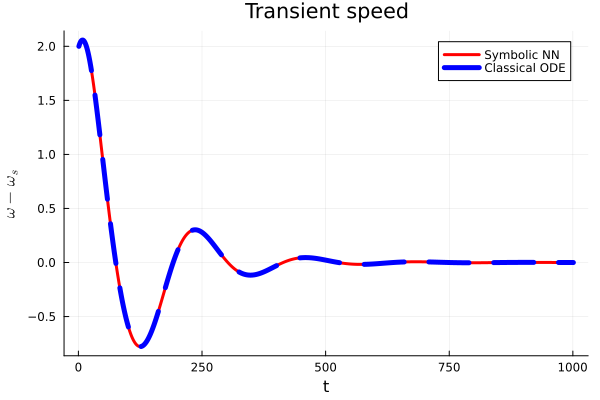

In [73]:
#Plotting the results.
using Plots
plot(u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,2],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Transient speed")
xlabel!("t")
ylabel!("\$ \\omega - \\omega_s \$")

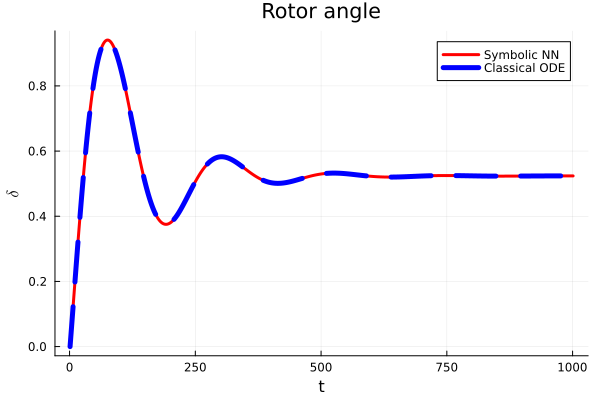

In [74]:
#Plotting the results.
using Plots
plot(u_predict[1,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Rotor angle")
xlabel!("t")
ylabel!("\$ \\delta \$")

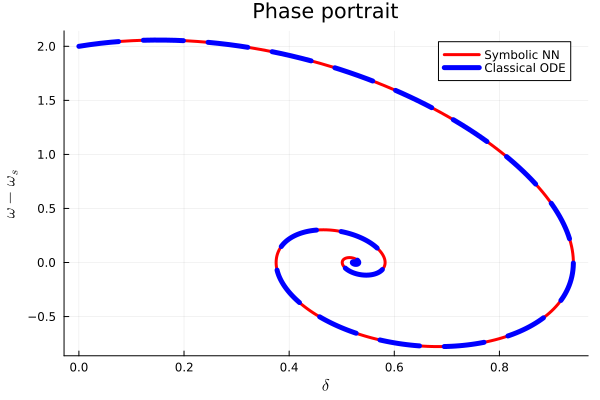

In [75]:
#Plotting the results.
using Plots
plot(u_predict[1,:], u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],sol[:,2], ls=:dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Phase portrait")
ylabel!("\$ \\omega - \\omega_s \$")
xlabel!("\$ \\delta \$")

In [ ]:
using DataFrames
using CSV
df = DataFrame(delta_NN = u_predict[1], omega_NN = u_predict[2], delta_ODE = sol[:,1], omega_ODE=sol[:,2]) #delta = 2, transient = 2
CSV.write("filename.csv", df; append = false) 

## Pole slipping

#### PINNs

In [88]:
@parameters t
@variables u1(..), u2(..)
D = Differential(t)
eq = [D(u1(t)) ~ u2(t),
    D(u2(t)) ~ 5 - 10*sin(u1(t))- 1.6*u2(t)];

In [ ]:
bcs = [u1(0) ~ -1.0, u2(0) ~ 7.0]
domains = [t ∈ Interval(0.0,15.0)]
dt = 0.01

input_ = length(domains) # number of dimensions
n = 10

chain =[Lux.Chain(Dense(input_,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,n,Lux.tanh),Dense(n,1)) for _ in 1:2]


@named pde_system = PDESystem(eq,bcs,domains,[t],[u1(t),u2(t)])

strategy = NeuralPDE.GridTraining(dt)

function additional_loss(phi, θ,p)
    return sum(sum(abs2, phi[i](t_ , θ[sep[i]]) .- u_[[i], :])/len for i in 1:1:2)
end

discretization = PhysicsInformedNN(chain, strategy, additional_loss = additional_loss, adaptive_loss  = NeuralPDE.GradientScaleAdaptiveLoss(10))
sym_prob = NeuralPDE.symbolic_discretize(pde_system, discretization)

pde_loss_functions = sym_prob.loss_functions.pde_loss_functions
bc_loss_functions = sym_prob.loss_functions.bc_loss_functions

iter = 0
maxiters = 50000
callback = function (p, l)
    global iter
    #Show the loss after 100 iterations.
    if iter % 100 == 0 || iter == maxiters
        println("loss: ", l,"\t\t","Iterations: $iter")
    end
    iter += 1
    return false
end

loss_functions =  [pde_loss_functions;bc_loss_functions]

function loss_function(θ,p)
    sum(map(l->l(θ) ,loss_functions))
end

f_ = OptimizationFunction(loss_function, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f_, sym_prob.flat_init_params)
res = Optimization.solve(prob,OptimizationOptimJL.BFGS(); callback = callback, maxiters = maxiters)

In [ ]:
phi = discretization.phi
ts = 0.0:0.01:15.0
minimizers_ = [res.u.depvar[sym_prob.depvars[i]] for i in 1:2]
u_predict  = [[phi[i]([t],minimizers_[i])[1] for t in ts] for i in 1:2];

#### Classical

In [ ]:
function SMIB(du,u,p,t)
    du[1] = u[2]
    du[2] = 5- 10*sin(u[1])-1.2*u[2]
end
u0 = [-1.0, 7.0]
h = 0.01
tspan = (0.0,15.0)
prob = ODEProblem(SMIB,u0,tspan);
sol = solve(prob,Tsit5(),dt = h,adaptive = false); # this is regular ODE
sol = transpose(sol);

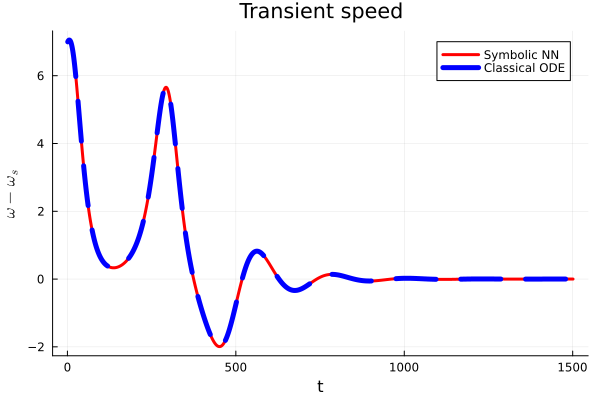

In [4]:
#Plotting the results.
using Plots
plot(u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,2],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Transient speed")
xlabel!("t")
ylabel!("\$ \\omega - \\omega_s \$")

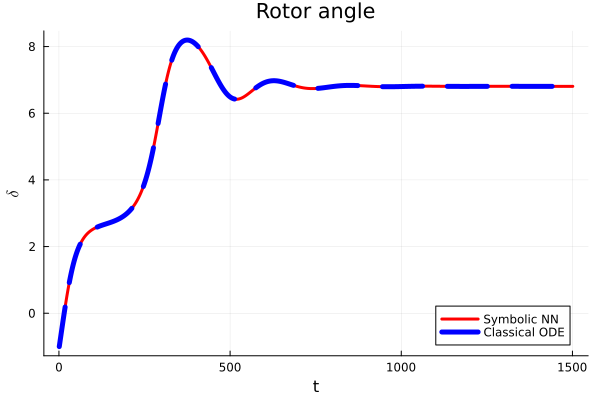

In [5]:
#Plotting the results.
using Plots
plot(u_predict[1,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Rotor angle")
xlabel!("t")
ylabel!("\$ \\delta \$")

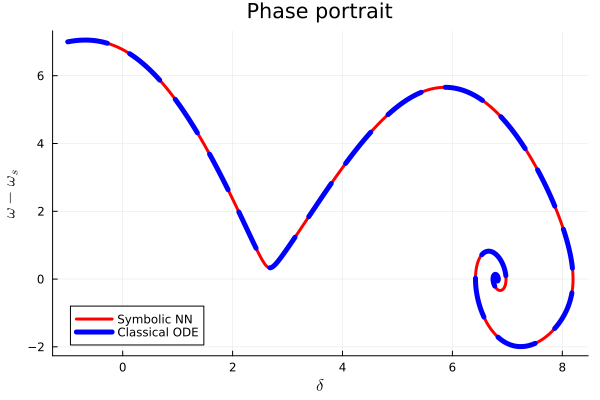

In [7]:
#Plotting the results.
using Plots
plot(u_predict[1,:], u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,1],sol[:,2], ls=:dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Phase portrait")
ylabel!("\$ \\omega - \\omega_s \$")
xlabel!("\$ \\delta \$")

In [ ]:
using DataFrames
using CSV
df = DataFrame(delta_NN = u_predict[1], omega_NN = u_predict[2], delta_ODE = sol[1:1501,1], omega_ODE=sol[1:1501,2]) #delta = 2, transient = 2
CSV.write("filename.csv", df; append = false) 